In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

# Defining Dataseat

In [14]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, seq_len=10000, random_start=True, noise=True):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.padder = torch.zeros(96, seq_len)
        self.labels = labels
        self.noise = noise
        self.random_start = random_start
#         self.labels = []
#         for i in range(len(self.files)):
#             label = np.random.randint(0, 10, size=15)
#             label[label > 8] = 0
#             label[label >= 1] = 1
#             self.labels.append(label)
#         for i in range(len(self.files)):
#             label = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#             self.labels.append(label)
    def __len__(self):
        return len(self.files)

#     def __getitem__(self, index):
#         return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])
    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
#         print(x.shape)
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        x = pad_sequence([x.T, self.padder.T], padding_value=-90, batch_first=True)[0].T
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1)

        if self.noise:
            x = torch.tensor(random_noise(x, mode='gaussian', mean=0, var=0.05, clip=False)).float()
#         input,label_ids,label
        item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[index])}
        return item
#         return x

In [15]:
from datasets import load_dataset

In [16]:
from datasets import disable_caching
disable_caching()

In [17]:
good_files = []
for i in range(1, 6):
    new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
    good_files.extend(new_files)

test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
print(good_files)
print(test_files)

['01/1009701.mp3', '01/1018801.mp3', '01/1052801.mp3', '01/1062501.mp3', '01/1086601.mp3', '01/1121101.mp3', '01/1125001.mp3', '01/1125401.mp3', '01/1157701.mp3', '01/1164201.mp3', '01/1167301.mp3', '01/1189901.mp3', '01/12101.mp3', '01/1210701.mp3', '01/1219101.mp3', '01/1245901.mp3', '01/1264201.mp3', '01/1304001.mp3', '01/1357701.mp3', '01/1380601.mp3', '01/1381001.mp3', '01/1396501.mp3', '01/1398501.mp3', '01/1398801.mp3', '01/1406401.mp3', '01/1420701.mp3', '01/16101.mp3', '01/292501.mp3', '01/361701.mp3', '01/390001.mp3', '01/399201.mp3', '01/554901.mp3', '01/661601.mp3', '01/708401.mp3', '01/718301.mp3', '01/759301.mp3', '01/80501.mp3', '01/824301.mp3', '01/842401.mp3', '01/846501.mp3', '01/913701.mp3', '01/986601.mp3', '02/1029002.mp3', '02/1032802.mp3', '02/1062502.mp3', '02/1066302.mp3', '02/1095102.mp3', '02/1121102.mp3', '02/1125402.mp3', '02/1164202.mp3', '02/1167302.mp3', '02/1189902.mp3', '02/12102.mp3', '02/1211802.mp3', '02/1266502.mp3', '02/1277702.mp3', '02/1337902.m

In [18]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [19]:
train_labels = files_to_labels(good_files)

In [20]:
test_labels = files_to_labels(test_files)

In [21]:
train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]

In [22]:
import time

In [23]:
# SEQ_LEN = 10000
SEQ_LEN = 3000

In [24]:
train_dataset = MusicDataset(train_np_files, train_labels, seq_len=SEQ_LEN, noise=True, random_start=True)
test_dataset = MusicDataset(test_np_files, test_labels, seq_len=SEQ_LEN, noise=False, random_start=True)

# MODEL TESTING
run dataset stuff first

In [25]:
inp = train_dataset[0]['input']
# inp = inp.unsqueeze(0)
inp.shape

torch.Size([1, 3000, 96])

### Structure we want

* downsample with CNN
* feed into transformer
* feed into linear layer
* profit

In [26]:
inp.shape

torch.Size([1, 3000, 96])

In [27]:
inp.unsqueeze(0)

tensor([[[[  3.7604,   8.3133,   9.3172,  ..., -19.9230, -32.3048, -42.2124],
          [ -2.1686,   0.0582,   8.4841,  ..., -26.6652, -35.4797, -50.7250],
          [  0.4147,   6.5989,   8.7675,  ..., -27.7342, -33.8952, -54.6984],
          ...,
          [-23.7416,  -9.3368,  -2.6597,  ..., -24.4586, -34.1481, -47.6866],
          [-23.1235, -13.3391,  -3.1436,  ..., -25.9516, -35.6146, -47.6477],
          [-14.8517, -13.4552, -10.0864,  ..., -20.5458, -26.9971, -42.5011]]]])

In [29]:
start_data = inp.unsqueeze(0)

In [30]:
conv = nn.Conv2d(1, 1, kernel_size=5, stride=(5, 1),padding=2)
# cout = conv(inp)
cout = conv(start_data)
cout.shape

torch.Size([1, 1, 600, 96])

In [31]:
# reshape so its function of 16
# cout = cout[:,:,:320]
cout = cout[:,:,:,:]
cout.shape

torch.Size([1, 1, 600, 96])

In [32]:
# patch_size = 16

In [33]:
# # put into patches
# patched = rearrange(cout, 'b (h s1) (w s2) -> b (h w) (s1 s2)', s1=patch_size, s2=patch_size)
patched = cout
patched.shape

torch.Size([1, 1, 600, 96])

In [37]:
class Patcher(torch.nn.Module):
    def forward(self, x):
#         x = x[:,:,:960]
#         x = x[:,:,:,:960]
        x = x.squeeze(1)
#         return rearrange(x, 'b (h s1) (w s2) -> b (h w) (s1 s2)', s1=patch_size, s2=patch_size)
        return x

Copying from:  https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/

In [38]:
patched = Patcher()(cout)

In [39]:
patched.shape

torch.Size([1, 600, 96])

In [42]:
# encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8)
encoder_layer = nn.TransformerEncoderLayer(d_model=96, nhead=8, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

In [45]:
transed = transformer_encoder(patched)
transed.shape

torch.Size([1, 600, 96])

In [46]:
# layer_norm = nn.LayerNorm(256)
layer_norm = nn.LayerNorm(96)
layered = layer_norm(transed)
layered.shape

torch.Size([1, 600, 96])

In [51]:
class BertPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
#         first_token_tensor = hidden_states[:,0]
        first_token_tensor = hidden_states[:,0,:]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [52]:
# bp = BertPooler(256)
bp = BertPooler(96)
bp(layered).shape

torch.Size([1, 96])

In [53]:
lined = nn.Linear(96, 15)

In [54]:
lined(first).shape

torch.Size([1, 15])

In [55]:
drop = nn.Dropout(0.1)

In [57]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.flatten()

In [59]:
x = start_data
for layer in [torch.nn.BatchNorm2d(1),
    conv,
    Patcher(),
#     Flatten()
#     Patcher(),
    transformer_encoder,
#         Flatten()
    layer_norm,
    bp,
#         Flatten()
    drop,]:
    x = layer(x)
    print(x.shape)

torch.Size([1, 1, 3000, 96])
torch.Size([1, 1, 600, 96])
torch.Size([1, 600, 96])
torch.Size([1, 600, 96])
torch.Size([1, 600, 96])
torch.Size([1, 96])
torch.Size([1, 96])


In [90]:
mod = nn.Sequential(
    torch.nn.BatchNorm2d(1),
    conv,
    Patcher(),
#     Flatten()
#     Patcher(),
    transformer_encoder,
#         Flatten()
    layer_norm,
    bp,
#         Flatten()
    drop,
#     lined
)

In [94]:
# mod(start_data).shape

In [95]:
model = mod

In [96]:
sum(p.numel() for p in model.parameters())

2607484

In [97]:
heads = [nn.Sequential(nn.Linear(96, 1), nn.Sigmoid()) for i in range(15)]
# heads = [nn.Sequential(nn.Linear(10688, 2), nn.Sigmoid()) for i in range(15)]
# heads = [nn.Sequential(nn.Linear(10240, 2), nn.Sigmoid()) for i in range(15)]

In [99]:
# heads[0](mod(start_data))

## Try Training

In [164]:
conv = nn.Conv2d(1, 1, kernel_size=5, stride=(5, 1),padding=2)
# encoder_layer = nn.TransformerEncoderLayer(d_model=96, nhead=8, batch_first=True)
encoder_layer = nn.TransformerEncoderLayer(d_model=96, nhead=2, batch_first=True)
# transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
layer_norm = nn.LayerNorm(96)
bp = BertPooler(96)
drop = nn.Dropout(0.1)

In [165]:
model = nn.Sequential(
    torch.nn.BatchNorm2d(1),
    conv,
    Patcher(),
    transformer_encoder,
    layer_norm,
    bp,
    drop,
)

In [166]:
heads = [nn.Sequential(nn.Linear(96, 96), nn.ReLU(), nn.Linear(96, 1), nn.Sigmoid()) for i in range(15)]

In [167]:
from torch.utils.data import DataLoader
# from transformers import AdamW
import torch.optim as optim

In [168]:
from tqdm import tqdm

In [169]:
batch_size = 8

In [171]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

test_dl = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [172]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
# device = torch.device('cuda')
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=5e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
# losses = [nn.CrossEntropyLoss() for i in range(15)]

In [173]:
device

device(type='cuda')

In [174]:
model = model.to(device)

In [175]:
import random

In [176]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        per_head_outputs = [h(outputs) for h in heads]
        
        for i in range(15):
            cur_loss = criterion(per_head_outputs[i].squeeze(1), labels[:,i].float())
            total_loss += cur_loss
    return total_loss.item()

In [177]:
model = model.to(device)
heads = [h.to(device) for h in heads]
model.train()
for h in heads:
    h.train()
    
train_losses = []
adjusted_train_losses = []
test_losses = []
# for epoch in range(10):
for epoch in range(10):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        per_head_outputs = [h(outputs) for h in heads]
        for i in range(15):
            cur_loss = criterion(per_head_outputs[i].squeeze(1), labels[:,i].float())
            these_losses.append(cur_loss)

        loss = sum(these_losses)
        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss
#     total_loss.backward()
        
#     total_loss += loss.item()
#         break
    with torch.no_grad():
        train_total_loss = get_total_loss(model, train_dl)
        test_loss = get_total_loss(model, test_dl)
        adjusted = total_loss
        train_losses.append(train_total_loss)
        adjusted_train_losses.append(adjusted.item())
        test_losses.append(test_loss)
    #     print(f"Epoch: {epoch}; Loss: {adjusted}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
        print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

model.eval()
for h in heads:
    h.eval()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.10it/s]


Epoch: 0; Loss: 168.98715209960938; Test Loss: 288.0355529785156


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.82it/s]


Epoch: 1; Loss: 164.74972534179688; Test Loss: 288.89453125


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.48it/s]


Epoch: 2; Loss: 164.64559936523438; Test Loss: 287.996337890625


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.82it/s]


Epoch: 3; Loss: 164.56292724609375; Test Loss: 287.50274658203125


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.19it/s]


Epoch: 4; Loss: 165.03675842285156; Test Loss: 287.6448974609375


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.49it/s]


Epoch: 5; Loss: 164.32321166992188; Test Loss: 286.4626770019531


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.64it/s]


Epoch: 6; Loss: 163.96865844726562; Test Loss: 289.27557373046875


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.35it/s]


Epoch: 7; Loss: 163.70578002929688; Test Loss: 286.75079345703125


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.49it/s]


Epoch: 8; Loss: 164.11773681640625; Test Loss: 286.3020324707031


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.82it/s]


Epoch: 9; Loss: 163.48651123046875; Test Loss: 286.13330078125


In [178]:
# adjusted_train_losses = [l.item() for l in adjusted_train_losses]

In [179]:
len(train_losses), len(test_losses), len(adjusted_train_losses)

(10, 10, 10)

<AxesSubplot:>

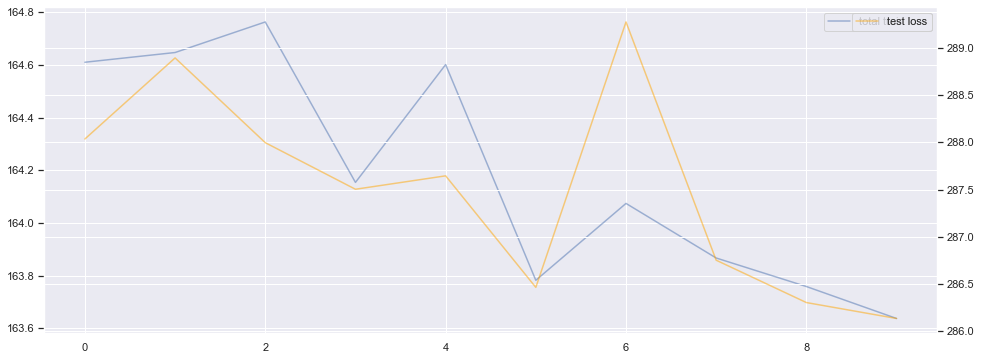

In [180]:
plt.figure(figsize=(16, 6))
ranger = list(range(len(train_losses)))
sns.lineplot(x=ranger, y=train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)

In [661]:
model.eval()
for h in heads:
    h.eval()
# In[ ]:


with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    for batch in test_dataset:
        outputs = model(batch['input'].to(device))

        labels = batch['labels']

        outputs = [h(outputs) for h in heads]
        # print(outputs[0].shape)
        # print(outputs[0])
        # print(labels)
        found_not_zero = False
        for i, o in enumerate(outputs):
            # output for each head
            pred = torch.argmax(o[0])
            # print(int(pred), int(labels[i]))
            # if pred == labels[i]:
                # print("COOL")
            total_correct += int(int(pred) == int(labels[i]))
            if int(pred) == 1:
                found_not_zero = True
            zero_correct += int(0 == int(labels[i]))
            total_values += 1
        if found_not_zero:
            print("NOT ZERO")
        # print(outputs)
        # outputs[outputs > 0] = 1
        # outputs[outputs < 0] = 0
        # total_correct += (labels == outputs.to('cpu')).sum()
        # total_values += len(labels)

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("JUST ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
NOT ZERO
0.4380952380952381
230 out of 525
JUST ZERO
0.9276190476190476
487 out of 525


In [248]:
525 / 15

35.0